### Project 1
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenburg)

The [Cocktail DB](https://www.thecocktaildb.com/api.php) is a database of cocktails and ingredients. In this assignment, we describe how we could use the Cocktail DB's API to generate a network of cocktails and ingredients. We can use some example data to explore how we might be able to predict outcomes from this data using centrality metrics. 

##### Loading the Data

Without digging too deeply into the intricacies of the Cocktail DB API, we can leverage [this code](https://holypython.com/api-12-cocktail-database/) as a start for grabbing some example output from the API. This code leverages 2 libraries: `requests` to make an API request, and `json` to load the JSON output from the API. We can then iterate through each cocktail output to grab the relevant components. 

We can bulid a search query to pull all cocktail names (`strDrink`), the ingredients for each, and the drink categories (`strCategory`) for each cocktail.

First, we get all drinks, by first letter of name.

In [1]:
import networkx as net
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
baseUrl = "https://www.thecocktaildb.com/api/json/v1/1/"
letterEndpoint = "search.php?f="

def searchLetter(letter):
    data = requests.get(baseUrl + letterEndpoint + letter)
    return json.loads(data.text)

In [3]:
# Build a dataframe
name = []  # drink name
ids = []   # drink ID
cat = []   # drink category
pic = []   # thumbnail url
ingr = []  # ingredients

In [4]:
# helper function to parse ingredients
def ingreds(drinkDict):
    ing = []
    for i in range(1,16):  # API has 16 fields for ingredients of each drink, most of them empty/None
        s = "strIngredient" + str(i)
        if not d[s]:
            break
        ing.append(d[s])
    return ing

In [9]:
for l in 'abcdefghijklmnopqrstuvwxyz':
    
    drinks = searchLetter(l)['drinks']
    if not drinks: continue   #(some letters have no drinks)
    for d in drinks:
        name.append(d['strDrink'])
        ids.append(d['idDrink'])
        cat.append(d['strCategory'])
        pic.append(d['strDrinkThumb'])
        ingr.append(ingreds(d))

In [13]:
drinkDF = pd.DataFrame({'name': name,
                       'id': ids,
                       'category': cat,
                       'photoURL': pic,
                       'ingredients': ingr})
drinkDF

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grand Marnier, Lemon Juice, Grenadine]"
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Amaretto, Baileys irish cream, Cognac]"
2,Ace,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grenadine, Heavy cream, Milk, Egg White]"
3,Adam,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Dark rum, Lemon juice, Grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Absolut Vodka, Gin, Tonic water]"
...,...,...,...,...,...
829,Zima Blaster,17027,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Zima, Chambord raspberry liqueur]"
830,Zizi Coin-coin,14594,Punch / Party Drink,https://www.thecocktaildb.com/images/media/dri...,"[Cointreau, Lemon juice, Ice, Lemon]"
831,Zippy's Revenge,14065,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Amaretto, Rum, Kool-Aid]"
832,Zimadori Zinger,15801,Punch / Party Drink,https://www.thecocktaildb.com/images/media/dri...,"[Midori melon liqueur, Zima]"


Save/load the df so as not to have to make 26 API calls every time notebook opens

In [14]:
#drinkDF.to_csv('drinkDF.csv')
#drinkDF = pd.read_csv('drinkDF.csv', index_col=0)

One more step needed on the load, since pandas converts lists to string literals on csv storage

In [15]:
#import ast
#drinkDF['ingredients'] = drinkDF.ingredients.apply(ast.literal_eval)

##### Make a bipartite graph, with cocktails as one type and ingredients as the other.

First we can play with a high-level graph of the full dataset, creating a bipartite graph where drinks are one type and ingredients are the other.

In [16]:
from networkx.algorithms import bipartite

name = drinkDF.name.values
cat = drinkDF.category.values
ingr = drinkDF.ingredients.values

drinks = set(name)
ingreds = set(i for iList in ingr for i in iList)

B = net.Graph()
B.add_nodes_from(drinks, bipartite='Cocktail')
B.add_nodes_from(ingreds, bipartite='Ingredient')

for d in range(len(drinkDF)):
    B.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        B.add_edge(name[d], ing)

Then the 2 bipartite projection graphs are these:

In [17]:
D = bipartite.weighted_projected_graph(B, drinks)
I = bipartite.weighted_projected_graph(B, ingreds)

#### Calculate Centrality by Category

Then we want to create sub-dataframes of 3 key categories: 'cocktail', 'shot', and 'ordinary drink', that we can then compare key centrality measures across.

In [18]:
drinks_cocktails = drinkDF[(drinkDF['category']=="Cocktail")]
drinks_cocktails.head()

,name,id,category,photoURL,ingredients
0,A1,17222,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grand Marnier, Lemon Juice, Grenadine]"
2,Ace,17225,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Grenadine, Heavy cream, Milk, Egg White]"
12,Addison,17228,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, Vermouth]"
16,Aviation,17180,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Gin, lemon juice, maraschino liqueur]"
21,Afterglow,12560,Cocktail,https://www.thecocktaildb.com/images/media/dri...,"[Grenadine, Orange juice, Pineapple juice]"


In [101]:
drinks_ordinary = drinkDF[(drinkDF['category']=="Ordinary Drink")]
drinks_ordinary.head()

,name,id,category,photoURL,ingredients
3,Adam,17837,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Dark rum, Lemon juice, Grenadine]"
4,AT&T,13938,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Absolut Vodka, Gin, Tonic water]"
6,A. J.,17833,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Applejack, Grapefruit juice]"
7,Affair,17839,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Strawberry schnapps, Orange juice, Cranberry ..."
9,Avalon,15266,Ordinary Drink,https://www.thecocktaildb.com/images/media/dri...,"[Vodka, Pisang Ambon, Apple juice, Lemon juice..."


In [20]:
drinks_shots = drinkDF[(drinkDF['category']=="Shot")]
drinks_shots.head()

,name,id,category,photoURL,ingredients
1,ABC,13501,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Amaretto, Baileys irish cream, Cognac]"
5,ACID,14610,Shot,https://www.thecocktaildb.com/images/media/dri...,"[151 proof rum, Wild Turkey]"
25,B-53,13332,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Kahlua, Sambuca, Grand Marnier]"
26,B-52,15853,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Baileys irish cream, Grand Marnier, Kahlua]"
29,Big Red,13222,Shot,https://www.thecocktaildb.com/images/media/dri...,"[Irish cream, Goldschlager]"


From the subsetted dataframes, create bipartite drink and ingredient graphs.

In [21]:
drinks_c = set(drinks_cocktails.name.values)
ingreds_c = set(i for iList in drinks_cocktails.ingredients.values for i in iList)

dc_graph = net.Graph()

dc_graph.add_nodes_from(drinks_c, bipartite='Drink')
dc_graph.add_nodes_from(ingreds_c,bipartite='Ingredient')

for d in drinks_cocktails.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        dc_graph.add_edge(name[d], ing)

Then we create a dataframe of degree and eigenvector centrality by each drink.

In [22]:
cocktail_degree = net.degree_centrality(dc_graph)
cocktail_degree = pd.DataFrame.from_dict(cocktail_degree, orient='index').reset_index()

In [23]:
cocktail_eig = net.eigenvector_centrality_numpy(dc_graph)
cocktail_eig = pd.DataFrame.from_dict(cocktail_eig, orient='index').reset_index()

We repeat these steps across the two other categories: 

In [99]:
drinks_o = set(drinks_ordinary.name.values)
ingreds_o = set(i for iList in drinks_ordinary.ingredients.values for i in iList)

do_graph = net.Graph()

do_graph.add_nodes_from(drinks_o, bipartite='Drink')
do_graph.add_nodes_from(ingreds_o,bipartite='Ingredient')

for d in drinks_ordinary.index:
    dc_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        dc_graph.add_edge(name[d], ing)

In [100]:
ordinary_degree = net.degree_centrality(do_graph)
ordinary_degree = pd.DataFrame.from_dict(ordinary_degree, orient='index').reset_index()

In [26]:
ordinary_eig = net.eigenvector_centrality_numpy(do_graph)
ordinary_eig = pd.DataFrame.from_dict(ordinary_eig, orient='index').reset_index()

In [27]:
drinks_s = set(drinks_shots.name.values)
ingreds_s = set(i for iList in drinks_shots.ingredients.values for i in iList)

ds_graph = net.Graph()

ds_graph.add_nodes_from(drinks_s, bipartite='Drink')
ds_graph.add_nodes_from(ingreds_s,bipartite='Ingredient')

for d in drinks_shots.index:
    ds_graph.add_node(name[d], category=cat[d])
    for ing in ingr[d]:
        ds_graph.add_edge(name[d], ing)

In [28]:
shots_degree = net.degree_centrality(ds_graph)
shots_degree = pd.DataFrame.from_dict(shots_degree, orient='index').reset_index()

In [29]:
shots_eig = net.eigenvector_centrality_numpy(ds_graph)
shots_eig = pd.DataFrame.from_dict(shots_eig, orient='index').reset_index()

##### Compare Centrality Measures across Categories
Then we can create summary dataframes of both centrality measures, and sort by each to see top 10 cocktails, shots, and ordinary drinks by each centrality measure.

In [78]:
summary_cocktails = pd.merge(cocktail_degree, cocktail_eig, how = "inner", on = "index")
summary_cocktails = summary_cocktails.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_cocktails['category'] = 'Cocktail'
summary_cocktails.head()

,Name,degree,eigenvector,category
0,Brigadier,0.012295,0.006473,Cocktail
1,Elderflower Caipirinha,0.012295,0.031961,Cocktail
2,Pegu Club,0.020492,0.167583,Cocktail
3,Oatmeal Cookie,0.020492,0.001177,Cocktail
4,Midnight Mint,0.012295,0.001055,Cocktail


In [79]:
summary_ordinary = pd.merge(ordinary_degree, ordinary_eig, how = "inner", on = "index")
summary_ordinary = summary_ordinary.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_ordinary['category'] = 'Ordinary'
summary_ordinary.head()

,Name,degree,eigenvector,category
0,Havana Cocktail,0.0,0.052066,Ordinary
1,Queen Elizabeth,0.0,0.066576,Ordinary
2,Gin Fizz,0.0,-0.077285,Ordinary
3,Pink Lady,0.0,0.013173,Ordinary
4,After sex,0.0,0.059509,Ordinary


In [80]:
summary_shots = pd.merge(shots_degree, shots_eig, how = "inner", on = "index")
summary_shots = summary_shots.rename(columns = 
        {"index":"Name","0_x":"degree","0_y":"eigenvector"})
summary_shots['category'] = 'Shots'
summary_shots.head()

,Name,degree,eigenvector,category
0,Mother's Milk,0.034483,0.012431,Shots
1,Jello shots,0.034483,0.127536,Shots
2,Bubble Gum,0.045977,0.166923,Shots
3,Kool First Aid,0.022989,0.041629,Shots
4,ACID,0.022989,0.040593,Shots


##### Digging into the Results

Then we can explore the values we see in centrality by each category. First we'll sort, to see how the highest values compare, and then we can look at means and medians.

In [81]:
summary_all = summary_cocktails
summary_all = summary_all.append([summary_shots,summary_ordinary])
summary_all.head()

,Name,degree,eigenvector,category
0,Brigadier,0.012295,0.006473,Cocktail
1,Elderflower Caipirinha,0.012295,0.031961,Cocktail
2,Pegu Club,0.020492,0.167583,Cocktail
3,Oatmeal Cookie,0.020492,0.001177,Cocktail
4,Midnight Mint,0.012295,0.001055,Cocktail


In [102]:
grouped_summary = summary_all.groupby("category")
mean_grouped = grouped_summary.mean()
mean_grouped = mean_grouped.reset_index()
mean_grouped

,category,degree,eigenvector
0,Cocktail,0.011743,0.034674
1,Ordinary,0.000000,0.000419
2,Shots,0.026907,0.069453


##### ANOVA Test

We can conduct an ANOVA test to see if the means across these groups are materially different.

Assumptions: 
- independence
- normally distributed within each group
- equal variances between all groups

Our hypothesis is that there is a difference in centrality between groups.

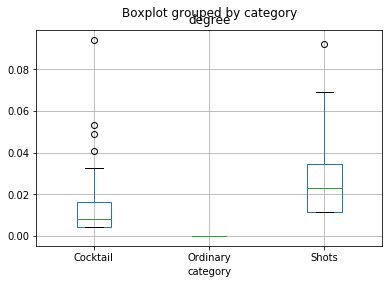

In [104]:
summary_all.boxplot('degree',by='category')

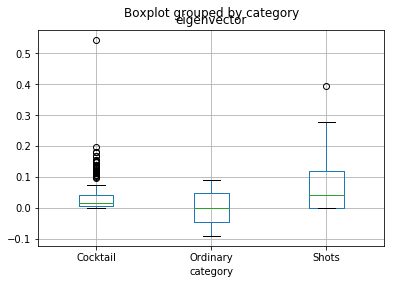

In [103]:
summary_all.boxplot('eigenvector',by='category')

In [129]:
# https://towardsdatascience.com/anova-test-with-python-cfbf4013328b
import scipy.stats as stats

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = summary_all['degree'].mean()
SSTR = summary_all.groupby('category').count() * (summary_all.groupby('category').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['degree'].sum()

# calculate SSE and update anova table
SSE = (summary_all.groupby('category').count() - 1) * summary_all.groupby('category').std()**2
anova_table['SS']['Within Groups'] = SSE['degree'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['degree'].sum() + SSE['degree'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = summary_all['category'].nunique() - 1
anova_table['df']['Within Groups'] = summary_all.shape[0] - summary_all['category'].nunique()
anova_table['df']['Total'] = summary_all.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,0.058254,2,0.029127,438.330273,0.0,3.708444
Within Groups,0.046382,698,0.000066,,,
Total,0.104636,700,0.000149,,,


In [130]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Null Hypothesis is rejected."
print("F-score is:", anova_table['F']['Between Groups'], " and critical value is:", anova_table['F crit']['Between Groups'])
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
F-score is: 438.33027299799846  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
F-score is: 438.33027299799846  and critical value is: 3.708443784853218
Null Hypothesis is rejected.


Check Assumptions

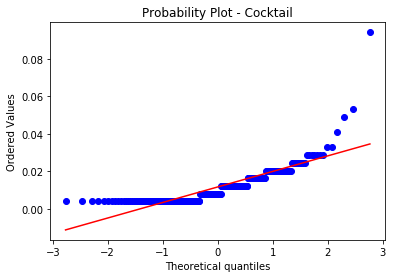

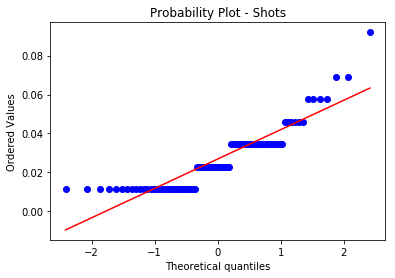

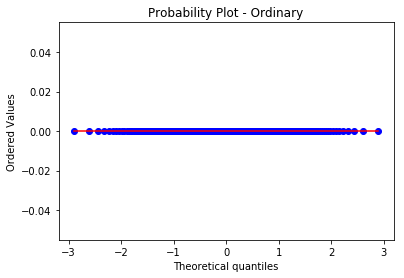

In [135]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['degree'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

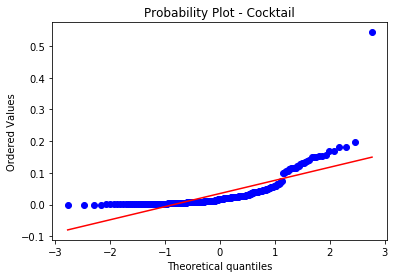

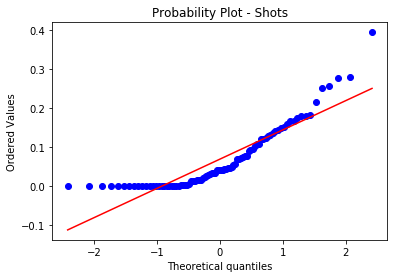

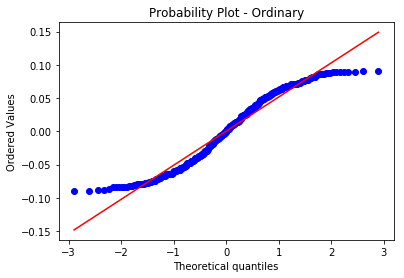

In [136]:
unique_cat = summary_all['category'].unique()
for category in unique_cat:
    stats.probplot(summary_all[summary_all['category'] == category]['eigenvector'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  category)
    plt.show()

In [137]:
# homogeneity of variance
ratio = summary_all.groupby('category').std().max() / summary_all.groupby('category').std().min()
ratio

degree              inf
eigenvector    1.558176
dtype: float64

##### Highest Centrality Drinks

In [132]:
summary_all.sort_values(by=['degree'],ascending=False).head()

,Name,degree,eigenvector,category
90,Gin,0.094262,0.543657,Cocktail
81,Vodka,0.091954,0.394175,Shots
66,Baileys irish cream,0.068966,0.255925,Shots
73,Amaretto,0.068966,0.277725,Shots
25,Flaming Dr. Pepper,0.057471,0.252010,Shots


In [133]:
summary_all.sort_values(by=['eigenvector'],ascending=False).head()

,Name,degree,eigenvector,category
90,Gin,0.094262,0.543657,Cocktail
81,Vodka,0.091954,0.394175,Shots
5,Kool-Aid Shot,0.057471,0.278812,Shots
73,Amaretto,0.068966,0.277725,Shots
66,Baileys irish cream,0.068966,0.255925,Shots


### clean up, figure out what's going on with Ordinary Drinks, add graph